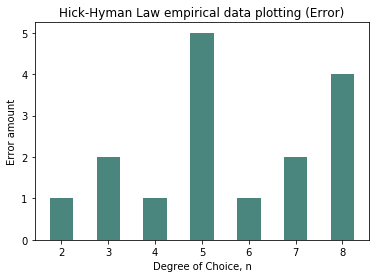

[2, 3, 3, 4, 5, 5, 5, 5, 5, 6, 7, 7, 8, 8, 8, 8]
Experiment 1 Done, thank you!


In [30]:
###############################################################################
# 2 Hick-Hyman Law
# ------------------------
# human performance principle depicting choice-reaction time
# First-time configuration:
#   From upper menu, gp to "Edit Keyboard Shortcuts" in "Help", delete Shortcuts
#   regarding 'A', 'E', 'R', 'G', 'H', 'U', 'I', 'L'
# GUI Usage:
#   1)  To yield ecologically valid result, please cover real-time data plotting
#       by GUI when performing hit-key experiment.
###############################################################################

import tkinter as tk
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
# import numpy as np
import random
import time as tm

class ExperimentAccurate(tk.Frame):
    # initial parameters
    gameAreaHeight = 300
    stimuliBasePosition = [200, -30]
    stimuliSideLength = 30
    stimuliFontSize = 20
    stimuliKey = ['S', 'L', 'E', 'I', 'R', 'U', 'G', 'H']
    stimuliTotalAmount = 8
    timeStart = []                                  # list of timestamp when generating each stimulus
    timeHit = []                                    # list of timestamp when hit each correct key
    timeDelta = []                                  # list of reaction time in millisecond
    plotTimeXList = []                              # list of stimuli amount as abscissa in plot RT ~ f(N)
    counterMax = 5                                  # to limit repeating times of hit-key experiment for a certain stimuli set size
    flagPause = True
    counterError = 0                                # record the amount of errors
    plotErrorList = []                              # list of error amount against the amount of stimuli, each entry in this list is the stimuli amount at that time
    def __init__(self, parent=None):
        tk.Frame.__init__(self, parent)
        self.pack()
        self.makeWidgets()                          # GUI layout
        self.defineStimuliCollection()
        self.stimuliAmount = 2                      # to increase the size of stimuli set
        self.generateStimuliSet(self.stimuliAmount) # generate required size of stimuli set
        self.counter = 0                            # to record repeating times of hit-key experiment so far
        self.generateRandomStimuli(self.indexList)  # generate 1 associated random stimulus
        self.animateStimuli()
        self.bind_all('<KeyPress>', self.onKeyHit)  # check user hit-key reaction
        self.bind_all('<space>', self.pauseContinue)    # press <space> to pause or continue key-hit experiment
    def makeWidgets(self):
        self.frameExplain = tk.Frame(self)
        self.frameGameArea = tk.Canvas(self, bd=2, bg='white', relief=tk.GROOVE, width=500, height=ExperimentAccurate.gameAreaHeight)
        self.frameBonus = tk.Frame(self)
        self.frameExplain.grid(row=0, column=0, padx=10, pady=10)
        self.frameGameArea.grid(row=1, column=0, padx=10, pady=10)
        self.frameGameArea.grid_propagate(0)
        self.frameBonus.grid(row=0, column=1, padx=10, pady=10)
        # buttonHelp = tk.Button(frameExplain, text="Usage Help", command=onHelpClicked)
        self.labelPause = tk.Label(self.frameExplain, text="Press <SPACE> key to START")
        # stimuli visualization
        self.stimuliVisualization = [0 for x in range(8)]
        for x in range(8):
            self.stimuliVisualization[x] = tk.Label(self.frameExplain, text=self.stimuliKey[x], relief=tk.GROOVE, width=5)
        self.labelRequirement = tk.Label(self.frameBonus, text="Please to be as accurate as possible")
        self.labelFeedback = tk.Label(self.frameBonus, text="chronoscope or hitting points here", bd=2, relief=tk.RAISED)
        # buttonHelp.grid(row=0, column=0, ipadx=10, ipady=10, padx=10, sticky=tk.W)
        self.labelPause.grid(row=0, column=0, columnspan=8, padx=10, sticky=tk.W)
        self.stimuliVisualization[0].grid(row=2, column=0, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[1].grid(row=2, column=7, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[2].grid(row=1, column=1, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[3].grid(row=1, column=6, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[4].grid(row=1, column=2, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[5].grid(row=1, column=5, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[6].grid(row=2, column=3, sticky=tk.NSEW, padx=10, pady=10)
        self.stimuliVisualization[7].grid(row=2, column=4, sticky=tk.NSEW, padx=10, pady=10)
        self.labelRequirement.grid(row=0, column=0, padx=10, pady=10)
        self.labelFeedback.grid(row=1, column=0, ipadx=10, ipady=10, padx=10, pady=10)
    def defineStimuliCollection(self):
        self.stimuli = [0 for x in range(8)]
        self.stimuliText = [0 for x in range(8)]
        for x in range(8):
            self.stimuli[x] = self.frameGameArea.create_rectangle(self.stimuliBasePosition[0], self.stimuliBasePosition[1], self.stimuliBasePosition[0] + self.stimuliSideLength, self.stimuliBasePosition[1] + self.stimuliSideLength, fill='#C0FFF8', activefill='#63B2A9', tags=self.stimuliKey[x], state=tk.HIDDEN)
            self.stimuliText[x] = self.frameGameArea.create_text(self.stimuliBasePosition[0] + 0.5*self.stimuliSideLength, self.stimuliBasePosition[1] + 0.5*self.stimuliSideLength, text=self.stimuliKey[x], font=self.stimuliFontSize, tags=self.stimuliKey[x], state=tk.HIDDEN)
    def generateStimuliSet(self, argAmount):
        self.indexList = []
        for i in range(argAmount):
            self.indexList.append(i)
            # visualize current stimuli set
            self.stimuliVisualization[i].config(relief=tk.RAISED, bg='#63B2A9', fg='white')
        # calculate speed from the size of stimuli set
        self.speed = 5
        self.counterTransit = 0
        self.transitStimuliSet()
        # self.frameGameArea.after(3000, self.transitStimuliSet)
    def transitStimuliSet(self):
        # blink updated stimuli set twice
        if self.counterTransit < 4:
            if self.stimuliVisualization[0].cget('state') == tk.NORMAL:
                for i in range(self.stimuliAmount):
                    self.stimuliVisualization[i].config(state=tk.DISABLED, bg='SystemButtonFace', relief=tk.GROOVE)
            else:
                for i in range(self.stimuliAmount):
                    self.stimuliVisualization[i].config(state=tk.NORMAL, bg='#63B2A9', relief=tk.RAISED)
            self.counterTransit += 1
            self.frameGameArea.after(500, self.transitStimuliSet)
        else:
            self.generateRandomStimuli(self.indexList)
    def generateRandomStimuli(self, argIndexList):
        # indexCurrent is a list
        self.indexCurrent = random.sample(argIndexList, 1)
        self.frameGameArea.itemconfigure(self.stimuli[self.indexCurrent[0]], state=tk.NORMAL)
        self.frameGameArea.itemconfigure(self.stimuliText[self.indexCurrent[0]], state=tk.NORMAL)
        self.frameGameArea.coords(self.stimuli[self.indexCurrent[0]], self.stimuliBasePosition[0], self.stimuliBasePosition[1], self.stimuliBasePosition[0] + self.stimuliSideLength, self.stimuliBasePosition[1] + self.stimuliSideLength)
        self.frameGameArea.coords(self.stimuliText[self.indexCurrent[0]], self.stimuliBasePosition[0] + 0.5*self.stimuliSideLength, self.stimuliBasePosition[1] + 0.5*self.stimuliSideLength)
        # record timestamp when generating this stimuli
        self.timeStart.append(tm.clock())
    # move stimuli downwards
    def animateStimuli(self):
        # press <space> can pause/continue animateStimuli function
        if self.flagPause == False:
            # if the user doesn't hit the correct key until the stimulus drops out,
            # it would count as an error, and generate a new stimulus
            if self.frameGameArea.coords(self.stimuli[self.indexCurrent[0]])[1] > self.gameAreaHeight+3:
                self.plotErrorList.append(self.stimuliAmount)
                if self.counter < self.counterMax - 1:
                    self.generateRandomStimuli(self.indexList)
                    self.counter += 1
                else:
                    if self.stimuliAmount < 8:
                        self.counter = 0
                        self.stimuliAmount += 1
                        self.generateStimuliSet(self.stimuliAmount)
                        self.generateRandomStimuli(self.indexList)
                    else:
                        self.flagPause = True
                        self.experiment1End()
            else:
                self.frameGameArea.move(self.stimuli[self.indexCurrent[0]], 0, self.speed)
                self.frameGameArea.move(self.stimuliText[self.indexCurrent[0]], 0, self.speed)
            self.frameGameArea.after(20, self.animateStimuli)
    def onKeyHit(self, event):
        # press <space> can pause/continue onKeyHit function
        if self.flagPause == False:
            # check if the user hit the correct key
            self.indexHit = []
            if event.char == self.stimuliKey[self.indexCurrent[0]] or event.char == self.stimuliKey[self.indexCurrent[0]].lower():
                self.indexHit.append(self.indexCurrent[0])
                self.frameGameArea.itemconfigure(self.stimuliKey[self.indexCurrent[0]], state=tk.HIDDEN)
                self.timeHit.append(tm.clock())
                self.timeDelta.append((self.timeHit[-1]-self.timeStart[-1])*1000)
                self.plotTimeXList.append(self.stimuliAmount)
                # repeat hit-key experiment for this size of stimuli set
                if self.counter < self.counterMax - 1:
                    self.generateRandomStimuli(self.indexList)
                    self.counter += 1
                    # plot Reaction Time against the amount of stimuli (i.e. size of stimuli set)
                    # fig = plt.figure()
                    # graph = fig.add_subplot(1,1,1)
                    # graph.set(title="Hick-Hyman Law empirical data fitting (Reaction Time)", ylabel="Reaction Time (ms)", xlabel="Degree of Choice, n")
                    # graph.scatter(self.plotTimeXList, self.timeDelta, color='#4A857E', alpha=0.5)
                    # plt.xticks(range(min(self.plotXList)-1, max(self.plotXList)+2, 1))
                    # plt.grid()
                    # display.clear_output(wait=True)
                    # plt.show()
                else:
                    # increase the size of stimuli set
                    if self.stimuliAmount < 8:
                        self.counter = 0
                        self.stimuliAmount += 1
                        self.generateStimuliSet(self.stimuliAmount)
                        # self.generateRandomStimuli(self.indexList)
                    else:
                        self.experiment1End()
            # record the amount of errors if the user hit a wrong key
            elif event.char.isalpha():
                self.counterError += 1
                self.plotErrorList.append(self.stimuliAmount)
    def pauseContinue(self, event):
        self.flagPause = not self.flagPause
        self.animateStimuli()
        if self.flagPause == True:
            self.labelPause.config(text="Press <SPACE> key to CONTINUE")
        else:
            self.labelPause.config(text="Press <SPACE> key to PAUSE at any time")
    def experiment1End(self):
        self.unbind_all('<KeyPress>')
        # self.bins = [2, 3, 4, 5, 6, 7, 8]
        # plot Error amount against the amount of stimuli (i.e. size of stimuli set)
        fig = plt.figure()
        graph = fig.add_subplot(1,1,1)
        graph.set(title="Hick-Hyman Law empirical data plotting (Error)", ylabel="Error amount", xlabel="Degree of Choice, n")
        graph.hist(self.plotErrorList, bins=7, range=(1.5, 8.5), align='mid', histtype='bar', rwidth=0.5, color='#4A857E')
        # plt.grid()
        display.clear_output(wait=True)
        plt.show()
        print (self.plotErrorList)
        print ("Experiment 1 Done, thank you!")

if __name__ == '__main__':
    root = tk.Tk()
    root.title("Hick-Hyman Law")
    root.resizable(width=False, height=False)
    ExperimentAccurate(root).mainloop()
